# Bootstrap validation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util

In [5]:
import sys
sys.path.append('/home/ssm-user/Github/single_cell_eb/')
sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
import scdd

### Approximate bootstrap

In [7]:
true_data = simulate.simulate_transcriptomes(10000, 5000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, .1, 0.011)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = 'PBMC'

In [8]:
size_factors = scdd.dd_size_factor(adata)
Nr = adata.X.sum(axis=1).mean()
_, M_dd = scdd.dd_1d_moment(adata, size_factor=size_factors, verbose=False, Nr=Nr)
var_scdd = scdd.M_to_var(M_dd)
num_boot = 100


In [421]:
estimator._poisson_1d(sp.sparse.csc_matrix(data_first_gene), adata.shape[0], size_factor=size_factors, n_umi=Nr)

[array([8.046989e-07], dtype=float32), array([1.0446381e-10], dtype=float32)]

In [422]:
boot_idxs

array([6924, 6913, 8122, ..., 3721, 4146, 2402])

In [423]:
%%time
#Real bootstrap
real_boot_vars = []
data_first_gene = adata.X[:, [0]].toarray()
for trial in range(num_boot):
    
    boot_idxs = np.random.choice(adata.shape[0], adata.shape[0], replace=True)
    mean, var = estimator._poisson_1d(sp.sparse.csc_matrix(data_first_gene[boot_idxs]), adata.shape[0], size_factor=size_factors[boot_idxs], n_umi=Nr)
    
    real_boot_vars.append(var[0])

CPU times: user 1min 11s, sys: 25.4 ms, total: 1min 11s
Wall time: 1min 11s


In [9]:
imp.reload(estimator)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(util)

adata_scmemo = adata.copy()
adata_scmemo.X = adata_scmemo.X.astype(np.int64)
scmemo.create_groups(adata_scmemo, label_columns=['ct'], inplace=True)
scmemo.compute_1d_moments(adata_scmemo, inplace=True, filter_genes=False, residual_var=True)

In [10]:
adata_scmemo.uns['scmemo']['1d_moments']['sg^PBMC'][1]

array([1.86722331e-10, 6.92497735e-09, 9.71589917e-11, ...,
       1.21792411e-11, 6.26090847e-09, 1.07144580e-09])

In [129]:
temp = adata.X[:, 1].toarray()


In [133]:
%%time
imp.reload(bootstrap)
a = bootstrap._precompute_size_factor(temp, adata_scmemo.uns['scmemo']['all_size_factor'], 2)

CPU times: user 63.4 ms, sys: 0 ns, total: 63.4 ms
Wall time: 62.6 ms


In [136]:
import string

In [158]:
%%time
df['bin'] = df.groupby('expr', sort=False)['size_factor'].mean()


CPU times: user 3.44 ms, sys: 0 ns, total: 3.44 ms
Wall time: 2.86 ms


In [188]:
%%time
df = pd.DataFrame()
df['expr'] = temp.reshape(-1)
df['size_factor'] = adata_scmemo.uns['scmemo']['all_size_factor']
df['bin_cutoff'] = df.groupby('expr', sort=False)['size_factor'].transform(np.mean)
df['bin'] = df['size_factor'] > df['bin_cutoff']
df['inv_size_factor'] = 1/df['size_factor']
df['inv_size_factor_sq'] = 1/df['inv_size_factor']
a = df.groupby(['expr','bin'], sort=False)['inv_size_factor'].mean()
b = df.groupby(['expr','bin'], sort=False)['inv_size_factor_sq'].mean()

CPU times: user 9.78 ms, sys: 0 ns, total: 9.78 ms
Wall time: 8.83 ms


In [254]:
%%time
df = pd.DataFrame(
    data=np.vstack([
        adata_scmemo.uns['scmemo']['all_size_factor'], 
        1/adata_scmemo.uns['scmemo']['all_size_factor'], 
        1/adata_scmemo.uns['scmemo']['all_size_factor']**2]).T,
    columns=['size_factor', 'inv_size_factor', 'inv_size_factor_sq'])

CPU times: user 0 ns, sys: 1.27 ms, total: 1.27 ms
Wall time: 772 µs


In [248]:
%%time
df = pd.DataFrame()
df['expr'] = temp.reshape(-1)
df['bin_cutoff'] = df.groupby('expr', sort=False)['size_factor'].transform(np.mean)
df['bin'] = df['size_factor'] > df['bin_cutoff']
a = df.groupby(['expr', 'bin'], sort=False)[['inv_size_factor', 'inv_size_factor_sq']].mean()
b = df.groupby(['expr', 'bin'], sort=False).size()

KeyError: 'Column not found: size_factor'

In [233]:
a

inv_size_factor  inv_size_factor_sq
expr bin                                       
2.0  True   0.768401         1.331998          
0.0  True   0.833723         1.233430          
1.0  False  1.351026         0.778836          
     True   0.799774         1.285852          
0.0  False  1.438275         0.735502          
3.0  False  1.197038         0.868858          
4.0  False  1.169557         0.878303          
2.0  False  1.229387         0.842320          
3.0  True   0.745841         1.371358          
4.0  True   0.750131         1.356245          
7.0  False  1.033685         0.999196          
     True   0.721391         1.405847          
5.0  True   0.680059         1.497037          
6.0  False  1.105216         0.936916          
5.0  False  1.060518         0.975786          
8.0  True   0.653392         1.547613          
6.0  True   0.699830         1.449041          
9.0  True   0.784755         1.282124          
11.0 True   0.585158         1.721527          
9.0  False  1.021504         0.983885          
15.0 True   0.516913         1.934589          
8.0  False  0.965392         1.071147          
10.0 True   0.616707         1.621515          
11.0 False  1.257874         0.836258          
10.0 False  0.667060         1.499115          
15.0 False  0.819310         1.220539

In [139]:
%%time
df = pd.DataFrame()
df['expr'] = temp.reshape(-1)
df['size_factor'] = adata_scmemo.uns['scmemo']['all_size_factor']
df['bin'] = df.groupby('expr', sort=False)['size_factor'].transform(lambda x: pd.cut(x, bins=2, labels=list(string.ascii_lowercase[:2])))
df['inv_size_factor'] = df.groupby(['expr','bin'], sort=False)['size_factor'].transform(lambda x: (1/x).mean())
df['inv_size_factor_sq'] = df.groupby(['expr','bin'], sort=False)['size_factor'].transform(lambda x: (1/x**2).mean())

CPU times: user 59.8 ms, sys: 3.72 ms, total: 63.6 ms
Wall time: 62.6 ms


In [123]:
%%time
imp.reload(bootstrap)
# res_1 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=1)
# res_2 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=2)
mean, var, res_var = bootstrap._bootstrap_1d(
    adata.X[:, 1], 
    size_factor=(df['inv_size_factor'].values, df['inv_size_factor_sq'].values), 
    n_umi=adata_scmemo.uns['scmemo']['n_umi'],
    num_boot=10000)


ValueError: Length of values does not match length of index

In [120]:
var.mean()

1.1132457274254674e-08

In [124]:
%%time
imp.reload(bootstrap)
# res_1 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=1)
# res_2 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=2)
mean, var, res_var = bootstrap._bootstrap_1d(
    adata.X[:, 1], 
    size_factor=adata_scmemo.uns['scmemo']['all_size_factor'], 
    n_umi=adata_scmemo.uns['scmemo']['n_umi'],
    num_boot=10000)


CPU times: user 119 ms, sys: 0 ns, total: 119 ms
Wall time: 119 ms


In [122]:
var.mean()

9.69564987646134e-09

In [463]:
from statsmodels.distributions.empirical_distribution import ECDF

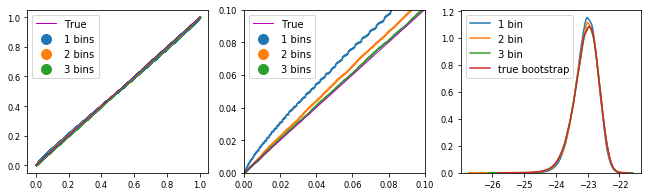

In [489]:
plt.figure(figsize=(11, 3))
plt.subplot(1, 3, 1)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 2)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.xlim(0, .1); plt.ylim(0, .1)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 3)
sns.distplot(np.log(res_1[1]), hist=False, label='1 bin')
sns.distplot(np.log(res_2[1]), hist=False, label='2 bin')
sns.distplot(np.log(res_3[1]), hist=False, label='3 bin')
sns.distplot(np.log(real_boot_vars), hist=False, label='true bootstrap')
